Visualize a single sample

In [1]:
import os, pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import agent, maze

In [135]:
# Parameters
agent_subdir = "results/aifg_dc4s_exp3_fixedseed/trial0"
pvrnn_data_path = "../LibPvrnn/results/2d_pftagent_rgbdc4s/aifg_exp3_fixedseed/trial0/pgstep"
step = 30
max_steps = 49
pg_samples = 1
prestep_agent_pos = True
pg_itr = 99
pg_plot = "AMu"
goal_pos = "" # override goal pos
# Override sample selection
sample = 0
argsample = -1

In [ ]:
## Load data
# with open(os.path.join(agent_subdir, "samples_er_step" + str(step) + ".pkl"), "rb") as ofile:
#     samples_er = pickle.load(ofile)
with open(os.path.join(agent_subdir, "samples_plan_step" + str(step) + ".pkl"), "rb") as ofile:
    samples_plan = pickle.load(ofile)
with open(os.path.join(agent_subdir, "all_sample_loss_step" + str(max_steps-1) + ".pkl"), "rb") as ofile:
    samples_loss = pickle.load(ofile)
with open(os.path.join(agent_subdir, "all_sample_agent" + str(step) + ".pkl"), "rb") as ofile:
    sample_agent = pickle.load(ofile)
with open(os.path.join(agent_subdir, "all_sample_ttraj" + str(step) + ".pkl"), "rb") as ofile:
    ttraj = pickle.load(ofile)

if "goal_pos" in sample_agent:
    goal_pos = sample_agent["goal_pos"]
else:
    goal_pos = None
    print("Missing goal_pos in sample_agent")

# Maintain sorted list
losses = []
vfactors = []
for t in range(1,max_steps):
    with open(os.path.join(agent_subdir, "all_sample_agent" + str(t) + ".pkl"), "rb") as ofile:
        sa = pickle.load(ofile)
        vfactors.append(sa["vfactor"])
vfactors = np.array(vfactors)
for s in range(pg_samples):
    sample_loss = np.asarray(samples_loss)[:,:,s]
    losses.append(sample_loss[step-1,0])

argloss = np.argsort(losses)

if sample >= 0:
    selected_sample = sample
elif argsample >= 0:
    selected_sample = argloss[argsample]
else:
    selected_sample = sample_agent["selected_sample"]

# Internal states
pvrnn_state = np.load(pvrnn_data_path + str(step) + ".npz")
pvrnn_state = dict(pvrnn_state)

In [137]:
## Setup experiment
world = maze.TMaze(goal_lr=goal_pos, rgb_color=True)
goal_pos = world.goal_lr
robot = agent.XYAgent(world=world, max_delta=0.2, max_sensor_range=0.75)
_robot_sense = sample_agent["robot_sense"]
if prestep_agent_pos:
    if step == 1:
        _robot_pos = [1.5, 1.5]
    else:
        with open(os.path.join(agent_subdir, "all_sample_agent" + str(step-1) + ".pkl"), "rb") as ofile:
            sample_agent = pickle.load(ofile)
        _robot_pos = sample_agent["robot_pos"]
        _robot_sense = sample_agent["robot_sense"]
        # _robot_corner = sample_agent["corner_sensors"]
        with open(os.path.join(agent_subdir, "all_sample_agent" + str(step) + ".pkl"), "rb") as ofile:
            sample_agent = pickle.load(ofile)
    robot.move(_robot_pos, force=True)
else:
    robot.move(sample_agent["robot_pos"], force=True)

Obstacle position: [1.8303796271906798, 2.5]


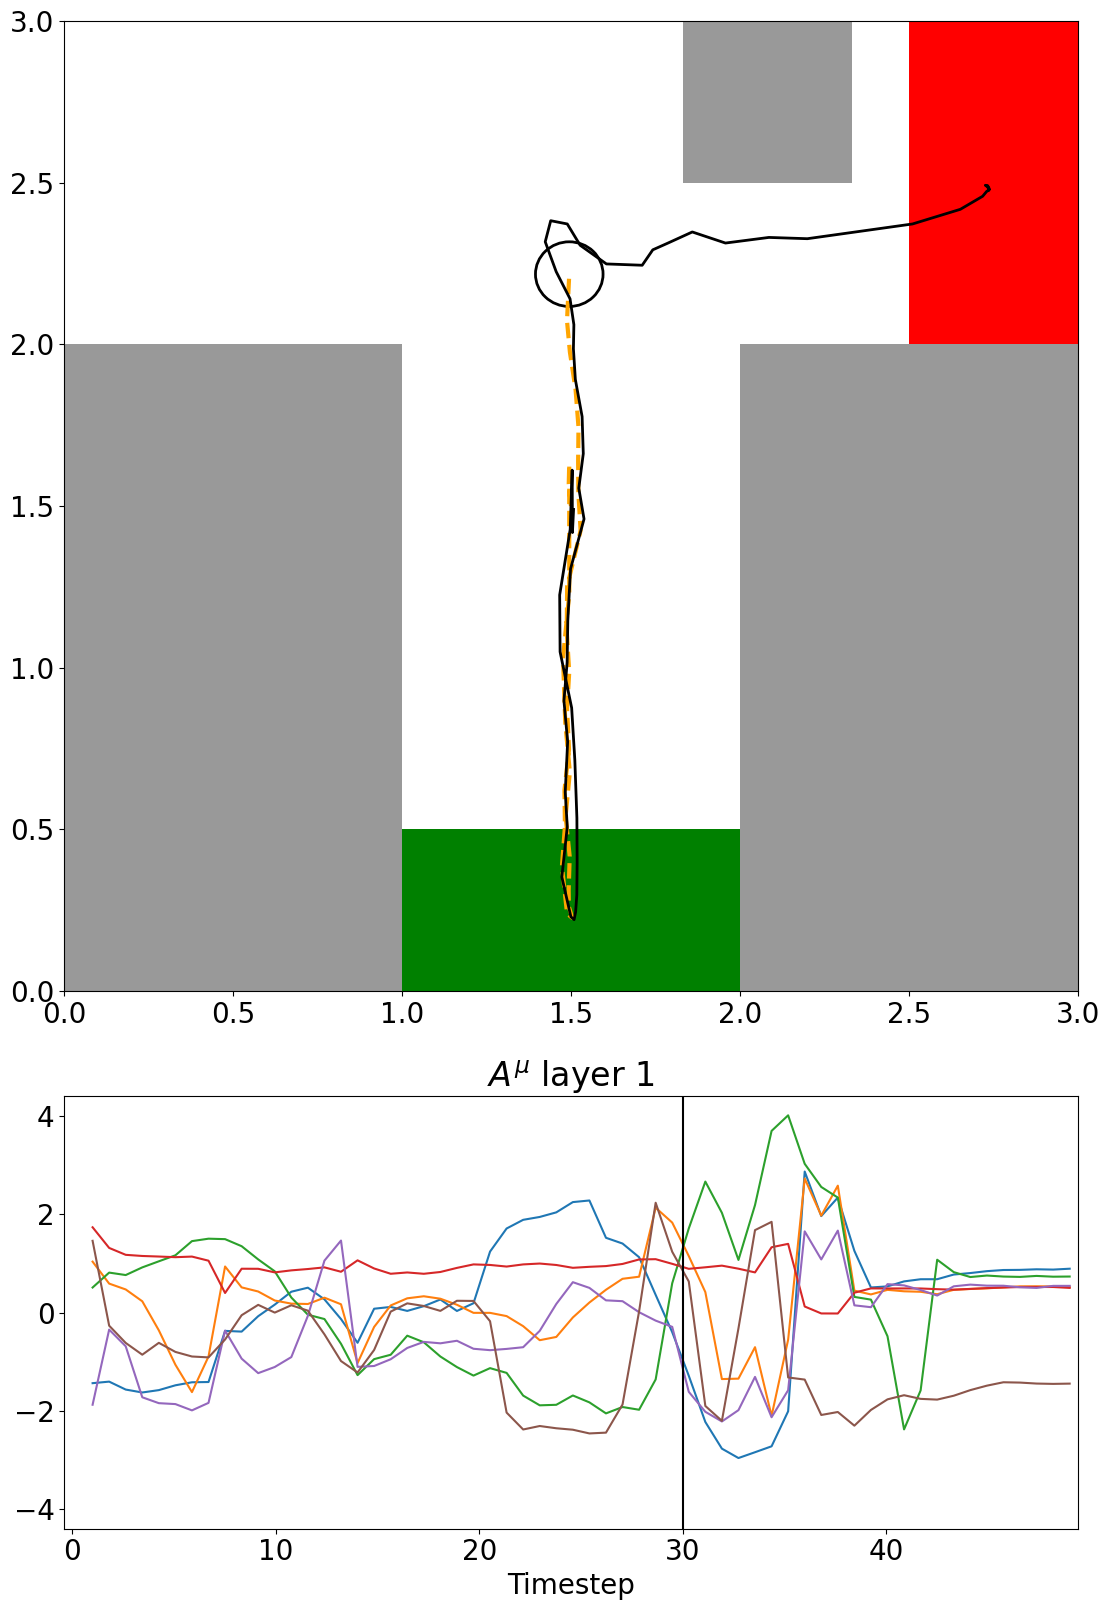

In [ ]:
## Plot
fig = plt.figure(figsize=(11.5,16.5))
font = {"size": 20}
plt.rc("font", **font)
gs = gridspec.GridSpec(nrows=3, ncols=1, figure=fig)
axs = []
axs.append(fig.add_subplot(gs[:2]))
axs.append(fig.add_subplot(gs[2]))
fig.set_dpi(100)

# XY view
axs[0].set_xlim(left=0.0, right=world.width)
axs[0].set_ylim(bottom=0.0, top=world.height)
# Walls
obstacle_pos = [1.8303796271906798, 2.5]
print("Obstacle position:", obstacle_pos)
world.set_obstacle(*obstacle_pos)
for w in world.walls:
    axs[0].add_patch(patches.Rectangle([w[0], w[1]], w[2]-w[0], w[3]-w[1], facecolor="0.6"))

# Colored floors
for c in world.colors:
    axs[0].add_patch(patches.Rectangle([c["pos"][0], c["pos"][1]], c["pos"][2]-c["pos"][0], c["pos"][3]-c["pos"][1], facecolor=world.convert_color(c["color"]), zorder=0))

# Agent
draw_robot = patches.Circle(robot.pos, 0.1, edgecolor="black", facecolor="white", linewidth=2)
draw_robot.set_facecolor(world.convert_color(_robot_sense))
if world.convert_color(_robot_sense) != "white":
    draw_robot.set_edgecolor("gray")
else:
    draw_robot.set_edgecolor("black")
axs[0].add_patch(draw_robot)

# Plans
for s in range(pg_samples):
    if s != selected_sample:
        axs[0].draw_artist(axs[0].plot(pvrnn_state["itr" + str(pg_itr) + "_s" + str(s) + "_output0_x"][:, 0], pvrnn_state["itr" + str(pg_itr) + "_s" + str(s) + "_output0_x"][:, 1], animated=False, color="gray", alpha=0.05)[0])
    else:
        axs[0].draw_artist(axs[0].plot(pvrnn_state["itr" + str(pg_itr) + "_s" + str(s) + "_output0_x"][:, 0], pvrnn_state["itr" + str(pg_itr) + "_s" + str(s) + "_output0_x"][:, 1], animated=False, color="black", alpha=1.0, linewidth=2, zorder=100)[0])
axs[0].draw_artist(axs[0].plot(np.asarray(ttraj)[:,0], np.asarray(ttraj)[:,1], animated=False, color="orange", alpha=1.0, linewidth=3, linestyle='--')[0]) # setup past traj

# Internal states
xsteps = np.linspace(1, max_steps, 60)
axs[1].set_xlim(left=-0.4, right=max_steps+0.4)
axs[1].set_ylim(bottom=-4.4, top=4.4)
for s in range(pg_samples):
    data = pvrnn_state["itr" + str(pg_itr) + "_s" + str(s) + "_layer1_" + pg_plot][:, :]
    axs[1].set_prop_cycle(None)
    if s != selected_sample:
        axs[1].draw_artist(axs[1].plot(xsteps, data, animated=False, alpha=0.015)[0])
    else:
        axs[1].draw_artist(axs[1].plot(xsteps, data, animated=False, alpha=1.0)[0])
axs[1].set_xlabel("Timestep")
axs[1].set_title(r"$A^\mu$ layer 1")
axs[1].axvline(step, color="black")

fig.tight_layout()
fig.savefig("dc4s_step"+str(step)+".png")
plt.show()